In [17]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from typing import Tuple
import itertools as it
import numba

In [18]:
# name = "T_S04856"
name = "T_S04923"

png_file = Path(f"./data/D3/D3/linearPNG/{name}.png")
tif_file = Path(f"./data/D3/D3/depth/depth{name}.tif")

In [19]:
clusters = 10

In [20]:
def uint8_2_double(array: np.ndarray):
    return array.astype(np.float64) / 255.0

def double_2_uint8(array: np.ndarray):
    return (array * 255).astype(np.uint8)

In [21]:
def imshow(img: np.ndarray, color_channel="rgb"):
    if img.dtype == np.float64 and len(img.shape) == 3:
        img = double_2_uint8(img)

    if color_channel == "bgr":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)

    if len(img.shape) == 2:
        plt.colorbar()

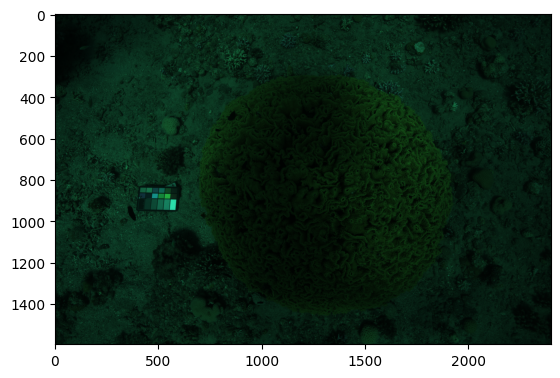

In [22]:
png = uint8_2_double(cv2.imread(png_file))
height, width, _ = png.shape

imshow(png, color_channel="bgr")

In [23]:
png.dtype

dtype('float64')

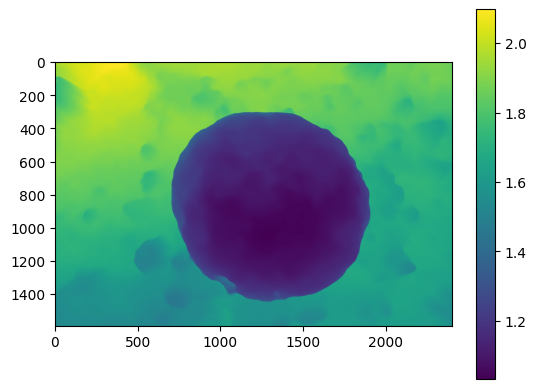

In [24]:
tif_image = Image.open(tif_file)
tif = np.array(tif_image)
tif = cv2.resize(tif, (width, height),  interpolation = cv2.INTER_NEAREST)

imshow(tif)

In [25]:
png.shape, tif.shape

((1596, 2400, 3), (1596, 2400))

In [26]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [27]:
tif_flat = tif.flatten().reshape(-1, 1)

## Backscatter Estimation

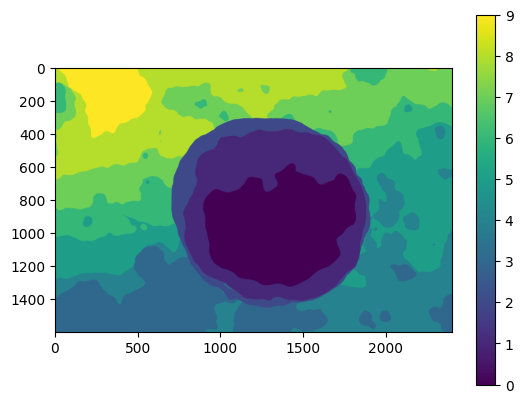

In [28]:
kmeans = KMeans(n_clusters=clusters, random_state=0, n_init="auto").fit(tif_flat)
labels = kmeans.labels_
means = np.array(kmeans.cluster_centers_).flatten()
means_args = np.argsort(means)

labels_new = np.zeros_like(labels)
for current_label in range(clusters):
    new_label = np.nonzero(means_args == current_label)[0]
    labels_new[labels == current_label] = new_label

labels = labels_new.reshape((height, width))
imshow(labels)

In [ ]:
dark_pixels = []
z_values = []

for i in range(clusters):
    mask = labels == i
    filtered = png * mask[:, :, np.newaxis]

    b = png[:, :, 0]
    g = png[:, :, 1]
    r = png[:, :, 2]

    b_filtered = b[mask].flatten()
    g_filtered = g[mask].flatten()
    r_filtered = r[mask].flatten()

    pixels = np.array([[b,g,r] for b,g,r in zip(b_filtered, g_filtered , r_filtered)])
    idx = np.nonzero(np.all(pixels <= np.percentile(pixels, 1, axis=0), axis=1))
    selected_pixels = pixels[idx]

    filtered_tif = tif[mask].flatten()
    z = filtered_tif[idx]

    dark_pixels.extend(selected_pixels.tolist())
    z_values.extend(z.tolist())

dark_pixels = np.array(dark_pixels)
z_values = np.array(z_values)

In [ ]:
dark_pixels.shape, z_values.shape

((48789, 3), (48789,))

In [ ]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [ ]:
z_values

array([1.11736989, 1.11718369, 1.11463082, ..., 2.01135969, 2.01256084,
       2.01059484], shape=(48789,))

In [ ]:
def estimate_backscatter(B_inf: float, beta_B: float, J_prime: float, beta_D_prime: float, z):
    return B_inf * (1 - np.exp(- beta_B * z)) + (J_prime * np.exp(- beta_D_prime * z))

In [ ]:
def optimize_estimate_backscatter(arguments: Tuple[float, float, float, float], B_hat: np.ndarray, z: np.ndarray):
    B_inf, beta_B, J_prime, beta_D_prime = arguments

    return np.sum((B_hat - estimate_backscatter(B_inf, beta_B, J_prime, beta_D_prime, z)) ** 2)

In [ ]:
result = minimize(optimize_estimate_backscatter, [1, 1, 1, 1], args=(dark_pixels[:, 0], z_values), bounds=[(0,1), (0,5), (0,1), (0,5)], method="SLSQP")
b_args = result.x

b_args

array([5.62685480e-01, 1.34526385e-02, 4.49971324e-14, 5.00000000e+00])

In [ ]:
optimize_estimate_backscatter(b_args, dark_pixels[:, 0], z_values)

np.float64(0.7324503388110648)

In [ ]:
result = minimize(optimize_estimate_backscatter, [1, 1, 1, 1], args=(dark_pixels[:, 1], z_values), bounds=[(0,1), (0,5), (0,1), (0,5)], method="SLSQP")
g_args = result.x

g_args

array([0.76810646, 0.01616228, 0.        , 2.5857675 ])

In [ ]:
optimize_estimate_backscatter(g_args, dark_pixels[:, 1], z_values)

np.float64(1.0677418375524539)

In [ ]:
result = minimize(optimize_estimate_backscatter, [1, 1, 1, 1], args=(dark_pixels[:, 2], z_values), bounds=[(0,1), (0,5), (0,1), (0,5)], method="SLSQP")
r_args = result.x

r_args

array([1.81550604e-01, 8.68709536e-03, 1.69371646e-15, 5.00000000e+00])

In [ ]:
optimize_estimate_backscatter(r_args, dark_pixels[:, 2], z_values)

np.float64(0.13036556095905305)

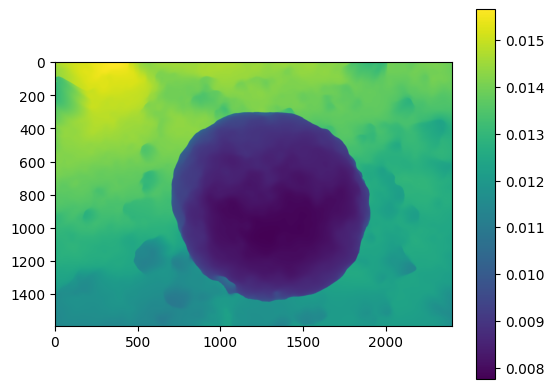

In [ ]:
B_b = estimate_backscatter(b_args[0], b_args[1], b_args[2], b_args[3], tif_flat).reshape((height, width))

imshow(B_b)

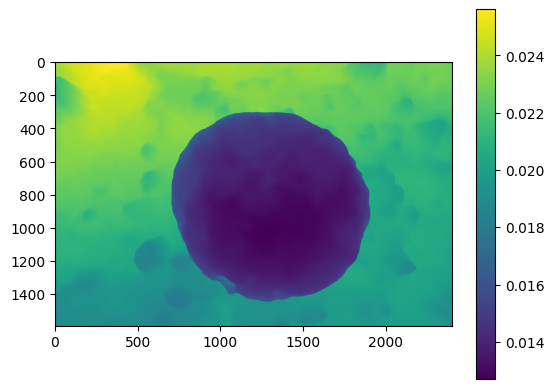

In [ ]:
B_g = estimate_backscatter(g_args[0], g_args[1], g_args[2], g_args[3], tif_flat).reshape((height, width))

imshow(B_g)

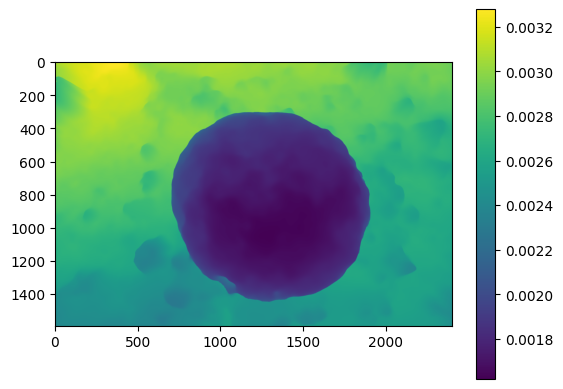

In [ ]:
B_r = estimate_backscatter(r_args[0], r_args[1], r_args[2], r_args[3], tif_flat).reshape((height, width))

imshow(B_r)

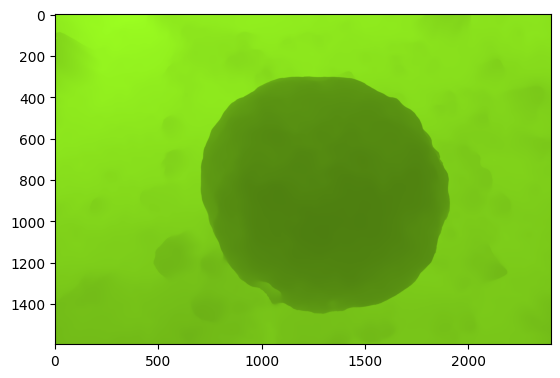

In [ ]:
backscatter = np.zeros((height, width, 3), dtype=np.float64)

backscatter[:, :, 0] = B_b
backscatter[:, :, 1] = B_g
backscatter[:, :, 2] = B_r

imshow(backscatter / backscatter.max())

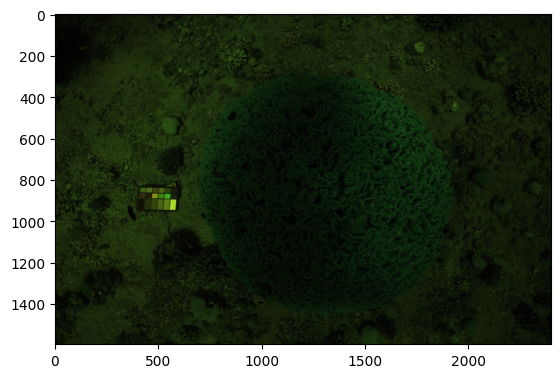

In [ ]:
direct_signal = png - backscatter
sig_min = direct_signal.min()

plt.imshow(direct_signal - sig_min)

## Attenuation Coefficient Estimation

In [ ]:
epsilon = 0.01

In [ ]:
# neighborhoods = np.zeros((height, width), dtype=np.uint8)
# all_points = {(int(y), int(x)) for y, x in it.product(np.arange(height), np.arange(width))}

# next_class = 1
# while np.any(neighborhoods == 0):
#     if np.all(neighborhoods == 0):
#         remaining_points = all_points.copy()
#     else:
#         set_points = {(int(y), int(x)) for y, x in np.array(np.nonzero(neighborhoods)).T.tolist()}
#         remaining_points = all_points.difference(set_points)

#     print(len(remaining_points))

#     start_point = remaining_points.pop()
#     z_value = tif[start_point[0], start_point[1]]

#     neighborhood = np.abs(tif - z_value) <= epsilon
#     filtered_neighborhood = np.zeros_like(neighborhood)

#     # Move down
#     y = start_point[0]
#     x = start_point[1]
#     while y < height and neighborhood[y, x]:
#         x = start_point[1]
#         filtered_neighborhood[y, x] = True

#         # Move Left
#         while x >= 0 and neighborhood[y, x]:
#             filtered_neighborhood[y, x] = True

#             x -= 1
#         x = start_point[1]

#         # Move Right
#         while x < width and neighborhood[y, x]:
#             filtered_neighborhood[y, x] = True

#             x += 1
#         x = start_point[1]

#         y += 1

#     # Move Up
#     y = start_point[0]
#     x = start_point[1]
#     while y >= 0 and neighborhood[y, x]:
#         x = start_point[1]
#         filtered_neighborhood[y, x] = True

#         # Move Left
#         while x >= 0 and neighborhood[y, x]:
#             filtered_neighborhood[y, x] = True

#             x -= 1
#         x = start_point[1]

#         # Move Right
#         while x < width and neighborhood[y, x]:
#             filtered_neighborhood[y, x] = True

#             x += 1
#         x = start_point[1]

#         y -= 1

#     neighborhoods[filtered_neighborhood] = next_class
#     next_class += 1

# imshow(neighborhoods)

3830400
3373197
3029423
2895401
2504525
2204869
1563483
1450386
1231614
822841
715398
435198
325763
286301
239038
226696
168269
127639
127631
113613
108271
104550
101673
80876
63759
62843
60029
56244
48997
43764
42852


KeyboardInterrupt: 